In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [4]:
from pmlb import fetch_data

X, y = fetch_data('1201_BNG_breastTumor', return_X_y=True)

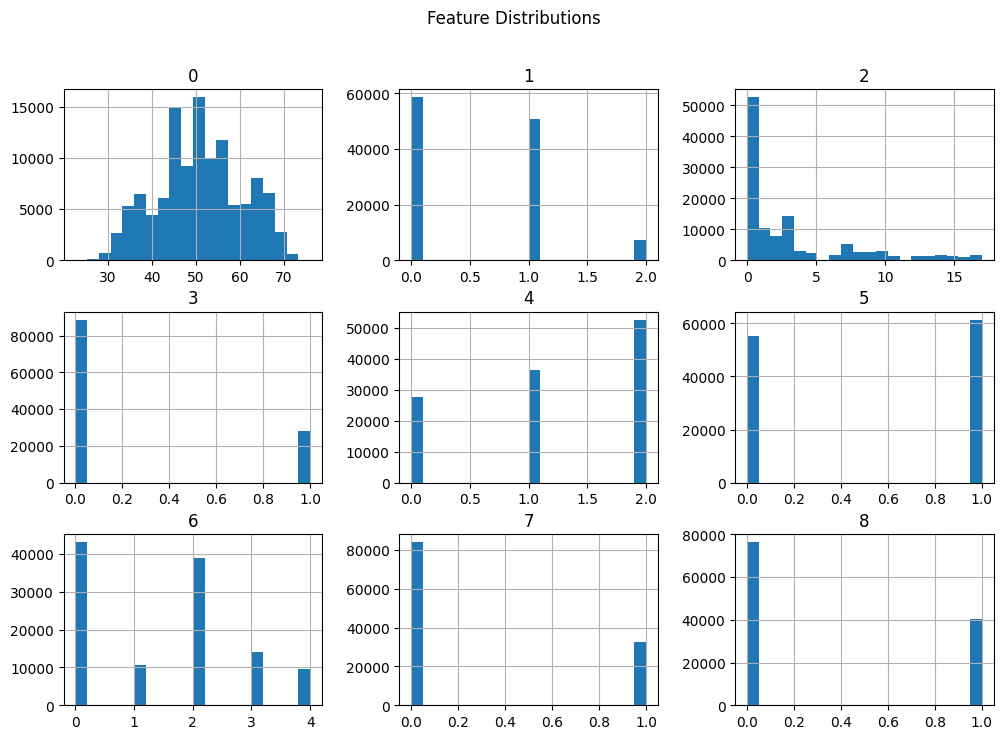

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

X_df = pd.DataFrame(X)
X_df.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

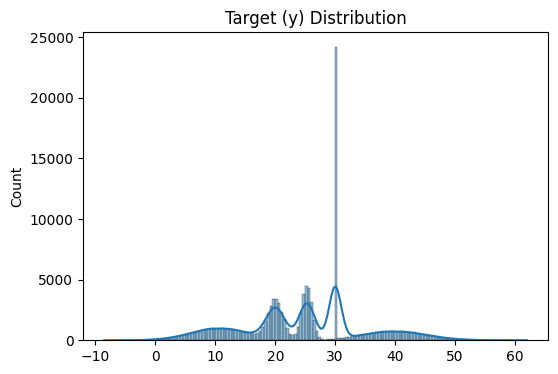

In [6]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

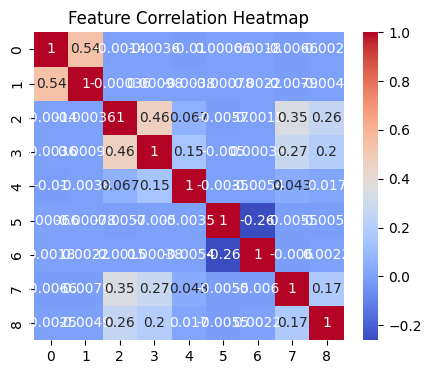

In [7]:
plt.figure(figsize=(5, 4))
corr = X_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [8]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=5, n_chains=4, ndpost=1000, nskip=1000, n_trees=100, n_jobs=5)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.000015                 1.010325             1.499993   
1                  1.008155                 1.014104             1.373993   
2                  1.002506                 1.013890             1.133403   
3                  1.016453                 1.007219             1.324962   
4                  1.008989                 1.003899             1.443730   
mean               1.007224                 1.009888             1.355216   
std                0.006391                 0.004387             0.140769   

      DefaultBART_Rhat_RMSE  
0                  1.112467  
1                  1.899493  
2                  1.169180  
3                  1.309509  
4                  1.360407  
mean               1.370211  
std                0.312556  


In [9]:
rhat_df.to_csv("results/real5_BreastTumor_rhat.csv", index=False)

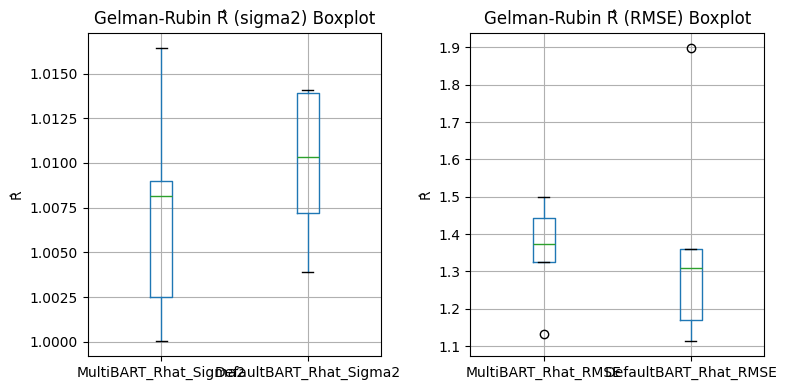

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

test_mse:
      bart_mtmh       bart        btz          rf        xgb
0     87.035352  87.470106  87.289641  109.458282  88.657922
1     87.305050  87.518497  87.319037  109.713743  88.580468
2     87.644464  87.845659  87.548842  110.045747  88.964341
3     87.741562  87.939690  87.834758  110.812855  89.112601
4     88.615232  88.840183  88.603959  110.663165  90.279935
5     87.679763  87.777957  87.901896  110.808684  89.136747
6     87.818519  87.881102  87.892939  111.041204  89.535712
7     88.073197  88.106423  88.076816  110.612982  89.441630
8     88.332875  88.497060  88.499003  111.407565  89.900800
9     87.433572  87.495417  87.466861  110.821577  88.721746
mean  87.767959  87.937209  87.843375  110.538580  89.233190
std    0.473670   0.445098   0.456904    0.609861   0.556879



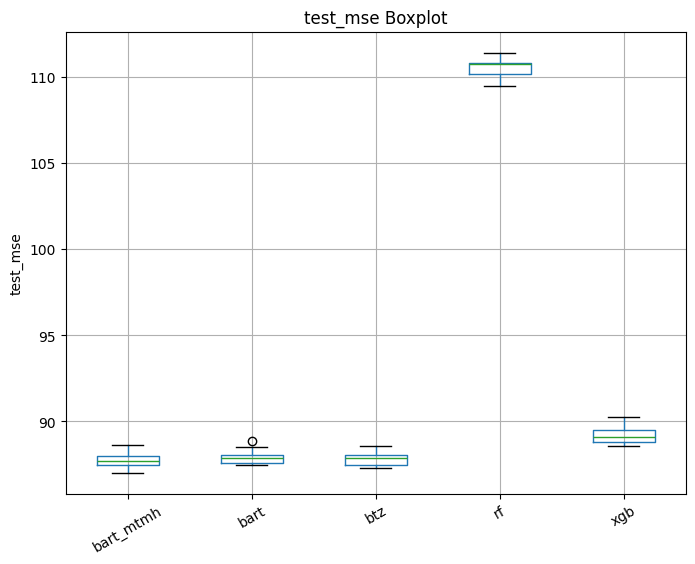

train_mse:
      bart_mtmh       bart        btz         rf        xgb
0     87.233088  87.614465  87.572981  15.534903  81.455847
1     87.299709  87.704266  87.598075  15.447441  81.404006
2     87.116576  87.511832  87.409541  15.395193  81.251570
3     87.122667  87.634694  87.548165  15.370045  81.250468
4     86.764331  87.259737  87.244632  15.341230  81.338999
5     87.186832  87.462235  87.536499  15.404729  81.252545
6     87.083050  87.517425  87.451229  15.432257  81.214583
7     87.102453  87.478294  87.415487  15.364956  81.153972
8     86.893716  87.269424  87.219002  15.369475  81.192552
9     87.255635  87.672521  87.615570  15.472823  81.257820
mean  87.105806  87.512489  87.461118  15.413305  81.277236
std    0.165103   0.154346   0.140914   0.059235   0.094540



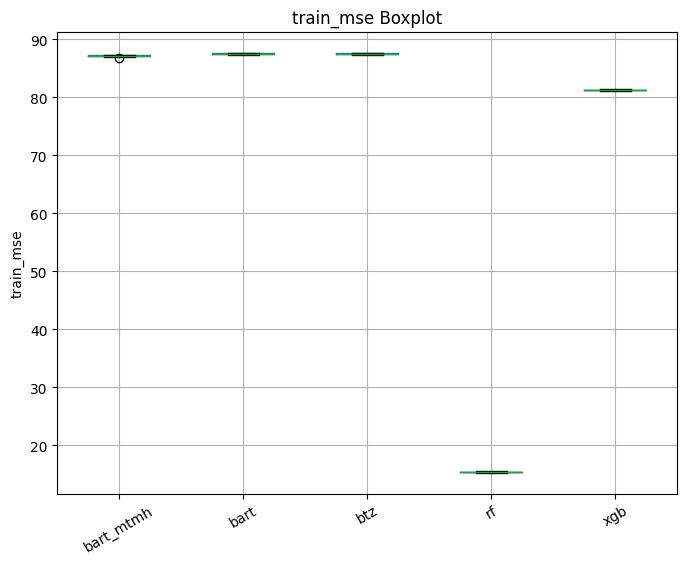

pi_length:
      bart_mtmh       bart        btz
0     36.583589  36.624950  36.717056
1     36.584953  36.645868  36.715176
2     36.547284  36.589733  36.689304
3     36.549642  36.619667  36.672443
4     36.476953  36.531638  36.624447
5     36.567128  36.594762  36.724834
6     36.547061  36.591304  36.669903
7     36.543613  36.586576  36.662045
8     36.510809  36.547445  36.666759
9     36.565401  36.616137  36.702358
mean  36.547643  36.594808  36.684433
std    0.032920   0.034846   0.031187



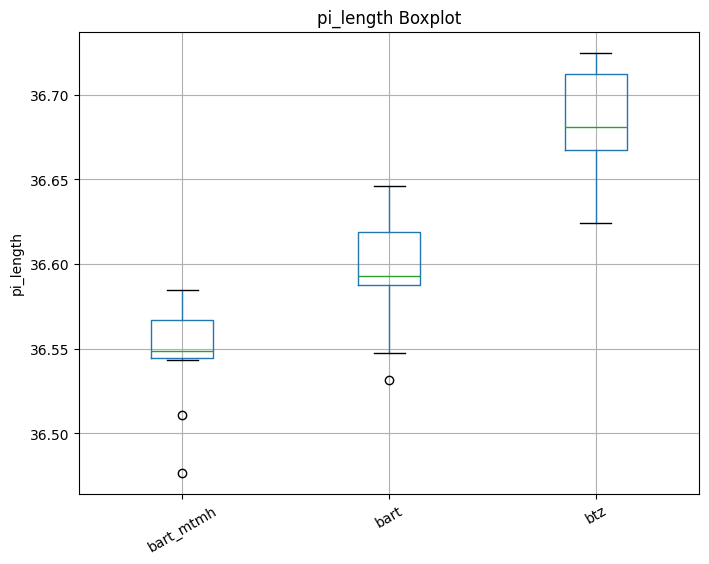

coverage:
      bart_mtmh      bart       btz
0      0.936660  0.937963  0.937243
1      0.936900  0.936248  0.938477
2      0.936248  0.936420  0.937997
3      0.936385  0.938683  0.937894
4      0.935357  0.935288  0.936077
5      0.937860  0.937620  0.938683
6      0.935528  0.936454  0.936077
7      0.937003  0.937483  0.938855
8      0.936111  0.935871  0.936248
9      0.935631  0.935700  0.937620
mean   0.936368  0.936773  0.937517
std    0.000771  0.001103  0.001069



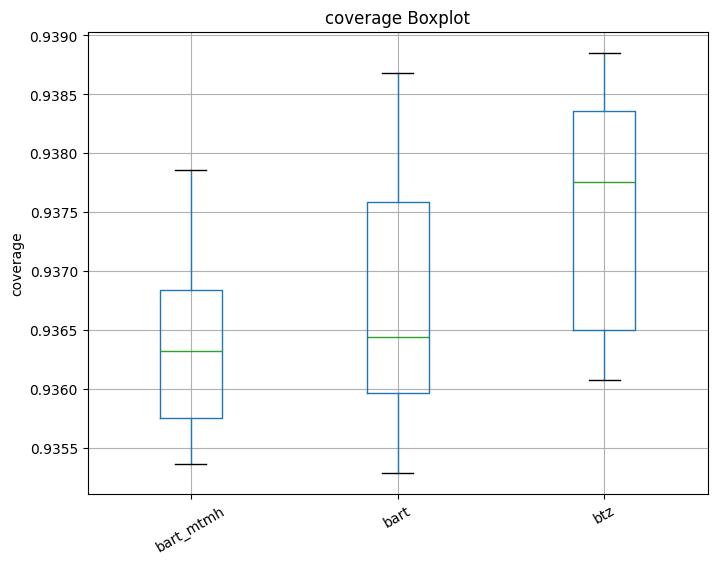

train_time:
        bart_mtmh        bart         btz         rf       xgb
0     1958.742693  356.626168  182.188391  32.165407  0.586070
1     1977.320539  348.131174  182.859607  28.158987  0.656945
2     1978.509344  365.905252  178.886037  25.657181  0.602987
3     1943.569661  346.050914  167.318753  49.979840  0.768272
4     1926.340257  348.868618  156.812040  51.769523  0.992714
5     2014.165790  355.677240  138.458112  33.953216  0.292942
6     2082.001722  408.117249  162.046486  34.457788  0.409529
7     2012.104413  373.699453  148.733453  27.949264  0.285934
8     2078.763228  399.881586  166.418365  27.826763  0.234199
9     2071.933530  417.670993  165.394291  23.918699  0.399675
mean  2004.345117  372.062865  164.911553  33.583667  0.522927
std     57.299660   26.850609   14.374098   9.735550  0.242607



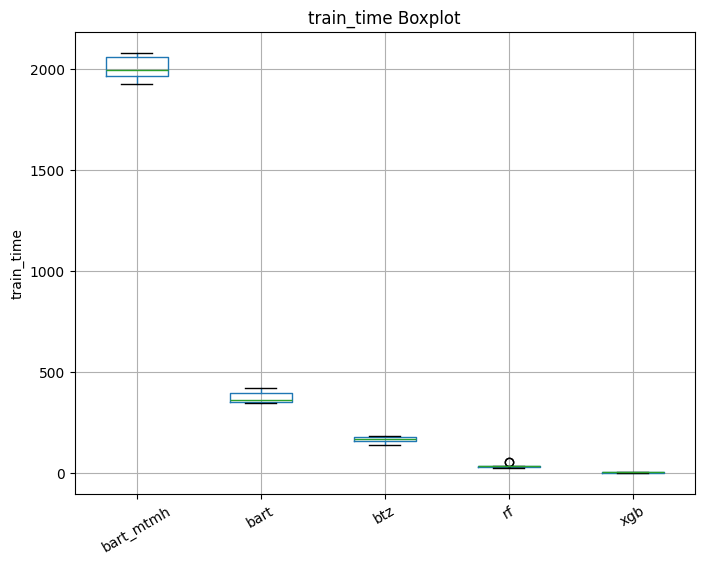

In [11]:
import matplotlib.pyplot as plt
import comparison
import pandas as pd

mse_results = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=1000, n_post=1000, n_trees=100, n_jobs=5)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [12]:
for k, v in mse_results.items():
    csv_name = f"results/real5_BreastTumor_{k}.csv"
    v.to_csv(csv_name, index=False)

## Multi-tries

In [ ]:
from multi_tries import multi_tries_performance
import pandas as pd

csv_path = "results/real5_BreastTumor_tries.csv"
existing_df = None

if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)

df = multi_tries_performance(
    X, y,
    multi_tries_list=[1, 5, 10, 50],
    n_runs=5, n_chains=4,
    ndpost=1000, nskip=1000, n_trees=100, n_jobs=5
)

if existing_df is not None:
    df = pd.concat([existing_df, df], ignore_index=True)
    df = df.sort_values(by='multi_tries', ascending=True).reset_index(drop=True)

df.to_csv("results/real5_BreastTumor_tries.csv", index=False)

In [14]:
print(df)

   multi_tries  Rhat_Sigma2  Rhat_RMSE   Test_MSE  Coverage   Train_Time
0            1     1.019142   1.531799  87.915006  0.936722   622.449667
1            5     1.004834   1.374026  87.770332  0.936605  1307.985470
2           10     1.007224   1.355216  87.630933  0.936283  2163.334613
3           50     1.005031   1.099639  87.480688  0.936420  7524.373794
